# IDMP Project

## Importing necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import xgboost as xgb

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Impoering Dataset

In [ ]:
data = pd.read_csv("/content/drive/My Drive/datasets/online_shoppers_intention.csv", header = 0)

## Data Preprocessing

#### We can have a quick look at the data type in each column of our dataset to make sure if there are any missing values. 

In [ ]:
data.dtypes

Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object

#### Month and VisitorType are object type, we can quickly check if there is any missing values by counting the values.

In [ ]:
print(data['Month'].value_counts())
print(data['VisitorType'].value_counts())

May     3364
Nov     2998
Mar     1907
Dec     1727
Oct      549
Sep      448
Aug      433
Jul      432
June     288
Feb      184
Name: Month, dtype: int64
Returning_Visitor    10551
New_Visitor           1694
Other                   85
Name: VisitorType, dtype: int64


## STEP 2 : Data preprocessing

#### As we have categorical features in our dataset, we need to encode them before so we can use them in our analysis later. 

In [ ]:
column_trans = make_column_transformer((OneHotEncoder(),['Month','OperatingSystems','Browser','VisitorType','Weekend']),remainder='passthrough')

# Scaler
scalar = MinMaxScaler()

# Purchased
dataset_p = data[data.Revenue==True]
# Not Purchased
dataset_np = data[data.Revenue==False]

# Downsampled Dataset
dataset_p_down = resample(dataset_p,replace=False,n_samples=1000)
dataset_np_down = resample(dataset_np,replace=False,n_samples=5000)
dataset = pd.concat([dataset_p_down,dataset_np_down])

# dataset = data
# from imblearn.over_sampling import SMOTEN

# smoten = SMOTEN(sampling_strategy='minority')

# Identifying the class label
X = dataset.drop(columns=['Revenue'], axis=1)
y = dataset['Revenue']

# Encoding categorical features
column_trans.fit(X)
X = column_trans.transform(X)

X = pd.DataFrame(X)

print(y.value_counts())

#X,y = smoten.fit_resample(X, y)

print(y.value_counts())

cols = list(X.columns)
pmax = 1

j = 1

while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(list(y),X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    if j < 2:
      print(model.summary())
      print(p.idxmax())
    j += 1
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05):
        cols.remove(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(selected_features_BE)

# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X[selected_features_BE],y,test_size=0.25,random_state=0)

# X_train, y_train = smoten.fit_resample(X_train, y_train)
# X_test, y_test = smoten.fit_resample(X_test, y_test)

# Center and normalize the data
scalar.fit(X[selected_features_BE])
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)

False    5000
True     1000
Name: Revenue, dtype: int64
False    5000
True     1000
Name: Revenue, dtype: int64
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     53.89
Date:                Mon, 13 Dec 2021   Prob (F-statistic):               0.00
Time:                        18:08:12   Log-Likelihood:                -1625.3
No. Observations:                6000   AIC:                             3337.
Df Residuals:                    5957   BIC:                             3625.
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------

In [ ]:
print(y_train.value_counts() + y_test.value_counts())
data['Revenue'].value_counts()

False    5000
True     1000
Name: Revenue, dtype: int64


False    10422
True      1908
Name: Revenue, dtype: int64

## STEP 3 : Data Visualisation

## Features correlation matrix

#### To have an idea of correlation between our variables we can plot the correlation matrix.

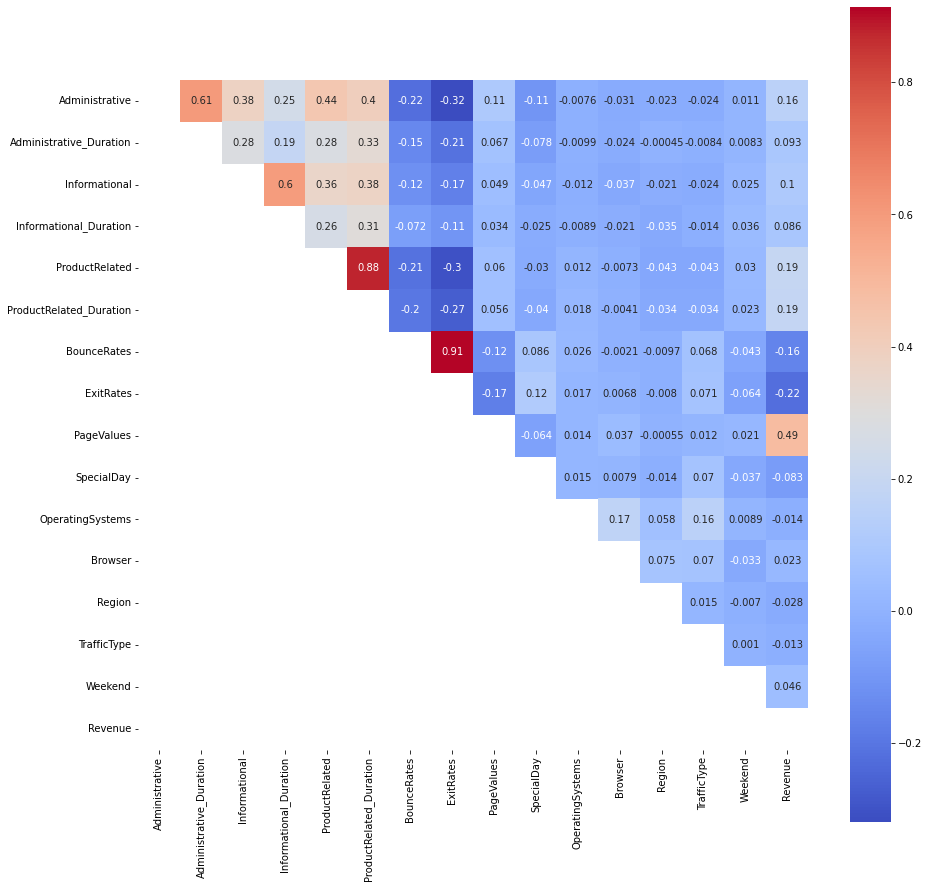

In [ ]:
plt.subplots(figsize=(15,15))
matrix = np.tril(data.corr())
sns.heatmap(dataset.corr(), annot = True, cmap= 'coolwarm',square=True,mask = matrix)

#### We see in the last column that the target is only correlated to a small number of variables in this dataset.

## Principal Component Analysis

#### We can use principal component analysis to see if we can have a good representation of our dataset in two or three dimensions. 

In [ ]:
# pca = PCA(n_components=20)
# X_train_pca = pca.fit_transform(X_train)
# per_var = np.round(pca.explained_variance_ratio_*100,decimals=1)
# labels = [str(x) for x in range(1,len(per_var)+1)]
# plt.rcParams['figure.figsize'] = (20, 10)
# font=20
# plt.bar(x=range(1,len(per_var)+1),height=per_var)
# plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
# plt.ylabel('Percentage of Explained Variance', fontsize = font)
# plt.xlabel('Principal Components', fontsize = font)
# plt.title('Scree Plot', fontsize = font)
# plt.show()

#### Because the percentage of explained variance decay slowly, it is not possible to represent well our dataset in two or three dimensions.

## 2D PCA Plot

#### We can have a look at our dataset in a 2D Plot.

In [ ]:
# X_r = pca.fit(X_train).transform(X_train)
# plt.figure()
# colors = ['darkorange', 'turquoise']
# lw = 2
# target_names= ["No Purchase","Purchase"]

# for color, i, target_name in zip(colors, [0, 1], target_names):
#     plt.scatter(X_r[y_train == i, 0], X_r[y_train == i, 1], color=color, alpha=.9, lw=lw,
#                 label=target_name)

# font=15
# plt.legend(loc='best', shadow=False, scatterpoints=1)
# plt.title('PCA',fontsize=font)
# pca100 = pca.explained_variance_ratio_
# D1 = "First principal component " + str(round(pca100[0] * 100,1)) + "%"
# D2 = "Second principal component " + str(round(pca100[1] * 100,1)) + "%"
# plt.ylabel(D1,fontsize=font)
# plt.xlabel(D2,fontsize=font)
# plt.rcParams['figure.figsize'] = (15, 10)
# plt.show()

#### There are 12 clusters that may correspond to the 12 months.

## Univariate Analysis

#### We can look at the dataset balance with a few bar plots.

In [ ]:
fig, axs = plt.subplots(1,2)
fig.set_size_inches(20,5)

#Visitor Types
axs[1].set_title("Visitor Types")
Vtype = ['Returning_Visitor','New_Visitor','Other']
count_vtype = [data['VisitorType'].value_counts()['Returning_Visitor'],
               data['VisitorType'].value_counts()['New_Visitor'],
               data['VisitorType'].value_counts()['Other']]
axs[1].bar(Vtype,count_vtype)

#Number of Purchased
axs[0].set_title("Revenue (Purchase/NoPurchase)")
TF = ["Purchase","No Purchase"]
TF_count = [data['Revenue'].value_counts()[True],data['Revenue'].value_counts()[False]]
axs[0].bar(TF,TF_count)

plt.show()

NameError: ignored

#### We have approximately 5 times more negative entries and most of our dataset is composed of Returning_Visitors

In [ ]:
plt.figure(figsize=(13, 4))
sns.countplot(dataset_p.Month.dropna(), order = data.Month.value_counts().index);
plt.title('Number of Purchase each month', fontsize = 15)

#### The number of 'purchase' is very important in November, maybe it is because of Black Friday ? ;)

In [ ]:
plt.figure(figsize=(13, 4))
sns.countplot(dataset_np.Month.dropna(), order = data.Month.value_counts().index);
plt.title('Number of No Purchase each month', fontsize = 15)

#### The number of “no purchase” sessions is more important in May, November, March and December, showing that there are more visits to the site these months.

## Bivariate analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


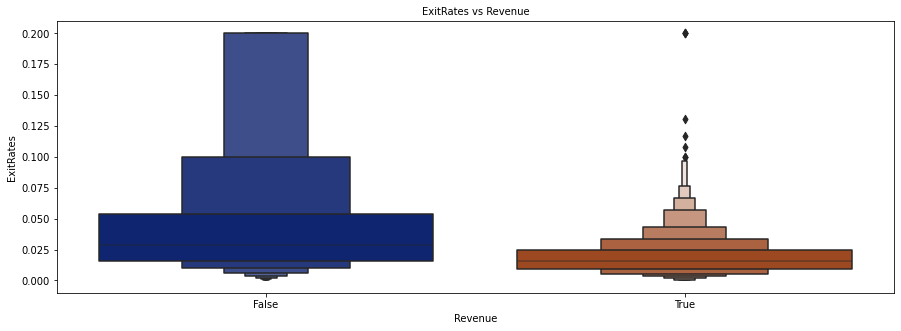

In [ ]:
plt.rcParams['figure.figsize'] = (15, 5)
# exit rate vs raevenue
sns.boxenplot(data['Revenue'], data['ExitRates'], palette = 'dark')
plt.title('ExitRates vs Revenue', fontsize = 10)
plt.xlabel('Revenue', fontsize = 10)
plt.ylabel('ExitRates', fontsize = 10)

plt.show()

#### Differences in ExitRates are not that significant by Revenue. We can note that the ExitRates are a little lower when there is a 'Purchase'.

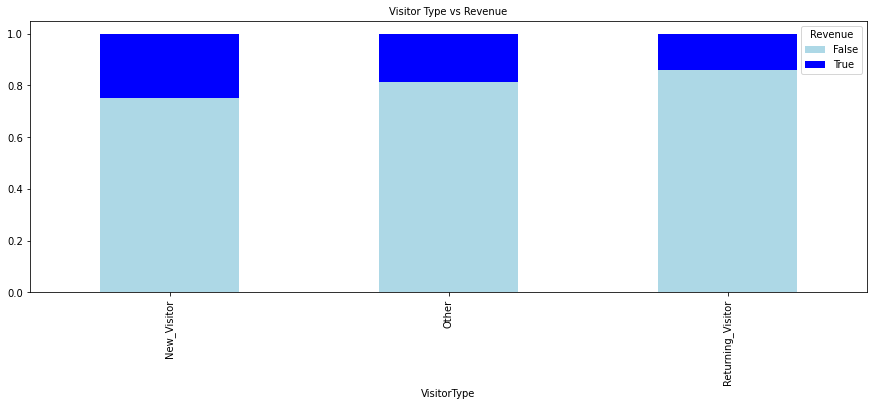

In [ ]:
df = pd.crosstab(data['VisitorType'], data['Revenue'])
df.div(df.sum(1).astype(float), axis = 0).plot(kind = 'bar', stacked = True, figsize = (15, 5), color = ['lightblue', 'blue'])
plt.title('Visitor Type vs Revenue', fontsize = 10)
plt.show()

#### This crosstab shows us that the Visitor_Type has almost no influence on the number of Purchases.

## Multivariate analysis

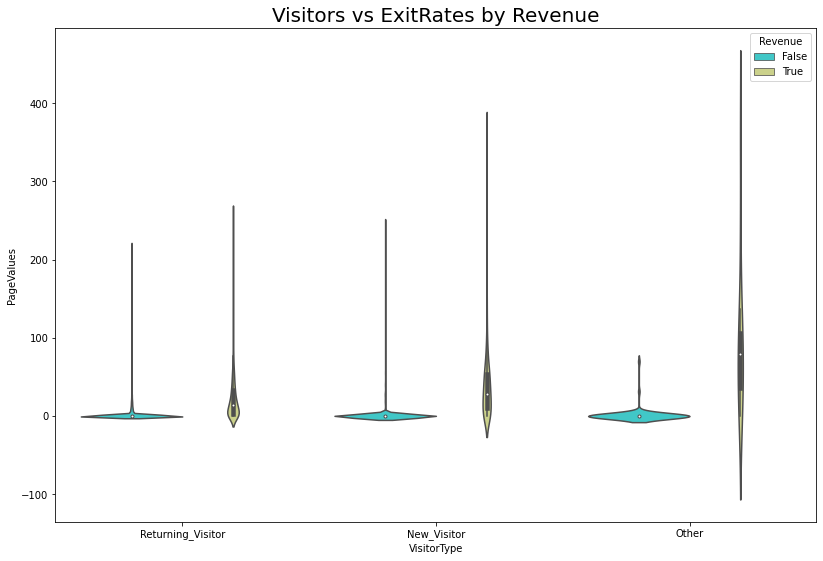

In [ ]:
plt.rcParams['figure.figsize'] = (30, 20)
plt.subplot(2, 2, 1)
sns.violinplot(x = data['VisitorType'], y = data['PageValues'], hue = data['Revenue'], palette = 'rainbow')
plt.title('Visitors vs ExitRates by Revenue', fontsize = 20)
plt.show()

#### The violin plot is showing us the same pattern for each visitor type. Page Value for most of the entries are close to 0 when the Revenue is False. But the values are spread out when Revenue is True. This may come from the definition of the PageValue, which gives a value close to 0 to pages which did not generate a lot of revenue.

## STEP 4: Building ML Model

## Overview of a few model's performance

#### Let's compare a few algorithms that can be used for classification to see the performance of each ones.

Naive Bayes 
 Accuracy: 0.8353333333333334 
 F-score 0.5277246653919694
Logistic Regression 
 Accuracy: 0.864 
 F-score 0.35443037974683544
K Nearest Neighbour 
 Accuracy: 0.846 
 F-score 0.37057220708446864
Support Vector Classification 
 Accuracy: 0.8586666666666667 
 F-score 0.2689655172413793
Decision Tree Classification 
 Accuracy: 0.8553333333333333 
 F-score 0.5525773195876289
Stochastic Gradient Descent 
 Accuracy: 0.87 
 F-score 0.41441441441441446
Linear Discriminant Analysis 
 Accuracy: 0.8693333333333333 
 F-score 0.44
Gradient Boosting Classification  
 Accuracy: 0.8886666666666667 
 F-score 0.6469344608879494
Random Forest Classification 
 Accuracy: 0.8906666666666667 
 F-score 0.6403508771929826


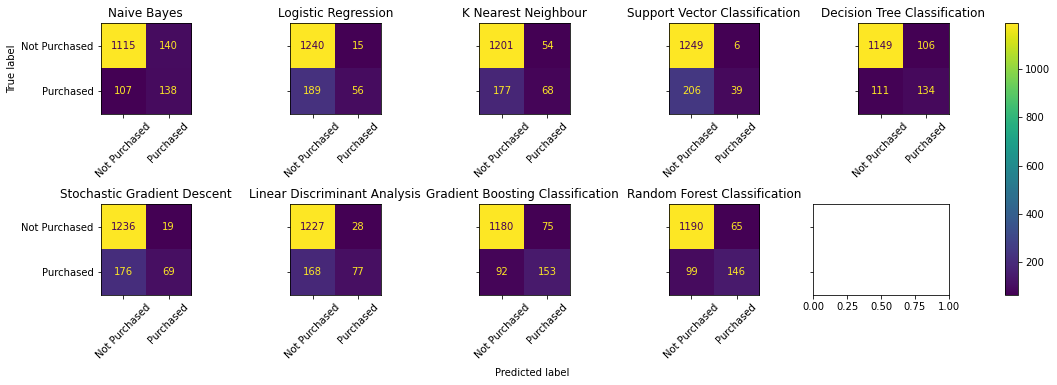

In [ ]:
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Logistic Regression": LogisticRegression(),
    "K Nearest Neighbour": KNeighborsClassifier(),
    "Support Vector Classification": SVC(),
    "Decision Tree Classification": DecisionTreeClassifier(),
    "Stochastic Gradient Descent": SGDClassifier(),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
    "Gradient Boosting Classification ": GradientBoostingClassifier(),
    "Random Forest Classification": RandomForestClassifier()
    }

f, axes = plt.subplots(2, 5, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    j = 0
    k = i
    if i>4:
        k = i-5
        j+=1
    
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(key, "\n Accuracy:",accuracy_score(y_test,y_pred),"\n F-score",f1_score(y_test,y_pred))
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=["Not Purchased","Purchased"])
    disp.plot(ax=axes[j][k], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.43, -0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=1)


f.colorbar(disp.im_, ax=axes)
plt.show()

#### The four best performing ones are Random Forest, Gradient Boosting, Stochastic Gradient Descent and Decision Tree.

## STEP 5 : Model Tuning (Grid Search)

#### We will tune the hyperparameters of our four best performing algorithms to see if we can improve the accuracy and f-score. We have to tune our parameters by the F-score because our dataset is unbalanced.

## Gradient Boosting

In [ ]:
parameters = [{
    "loss":["deviance"],
    "learning_rate": [0.2,0.3,0.4],
    "min_samples_split": [0.01,0.1, 0.5],
    "min_samples_leaf": [0.0001,0.001, 0.01],
    "max_depth":[8,10,15],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "absolute_error"],
    "subsample":[0.7,0.8,0.9],
    "n_estimators":[10,20,30]
    }]
gbm = RandomizedSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1,scoring='f1', verbose=True)
gbm.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions=[{'criterion': ['friedman_mse',
                                                       'absolute_error'],
                                         'learning_rate': [0.2, 0.3, 0.4],
                                         'loss': ['deviance'],
                                         'max_depth': [8, 10, 15],
                                         'max_features': ['log2', 'sqrt'],
                                         'min_samples_leaf': [0.0001, 0.001,
                                                              0.01],
                                         'min_samples_split': [0.01, 0.1, 0.5],
                                         'n_estimators': [10, 20, 30],
                                         'subsample': [0.7, 0.8, 0.9]}],
                   scoring='f1', verbose=True)

In [ ]:
print(gbm.best_params_)

{'subsample': 0.9, 'n_estimators': 20, 'min_samples_split': 0.01, 'min_samples_leaf': 0.01, 'max_features': 'sqrt', 'max_depth': 10, 'loss': 'deviance', 'learning_rate': 0.2, 'criterion': 'friedman_mse'}


In [ ]:
# Gradient boosting with best parameters
gs_gbm = GradientBoostingClassifier( 
    **gbm.best_params_
)
gs_gbm.fit(X_train, y_train)
gs_gbm.score(X_test,y_test)

0.892

## Support Vector Classifier

In [ ]:
svm = SVC()
parameters = {"C": np.arange(2, 10, 2),
             "gamma": np.arange(0.1, 1, 0.2),
             'kernel': ['linear', 'rbf']}
svm = RandomizedSearchCV(svm, parameters, cv=5, n_jobs=-1,scoring='f1', verbose=True)
svm.fit(X_train,y_train)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
                   param_distributions={'C': array([2, 4, 6, 8]),
                                        'gamma': array([0.1, 0.3, 0.5, 0.7, 0.9]),
                                        'kernel': ['linear', 'rbf']},
                   scoring='f1', verbose=True)

In [ ]:
print(svm.best_params_)

{'kernel': 'linear', 'gamma': 0.30000000000000004, 'C': 8}


In [ ]:
# Stochastic gradient descent with best parameters
gs_svm = SVC(**svm.best_params_)
gs_svm.fit(X_train, y_train)
gs_svm.score(X_test,y_test)

0.878

## Random Forest

In [ ]:
parameters = [{
    "criterion": ["gini",  "entropy"],
    "n_estimators": [200,400,600,800,1000],
    "max_features": ['auto', 'sqrt'],
    "max_depth": [5, 50, 100],
    "min_samples_split": [5,10,15,20,25,30], 
    "min_samples_leaf": [1,5,10,15,20],
    "bootstrap": [True, False]
             }]

rf = RandomizedSearchCV(RandomForestClassifier(), 
                  parameters, 
                  cv=5, 
                  n_jobs=-1,
                  scoring='f1', 
                  verbose=True)

rf.fit(X_train,y_train)

NameError: ignored

In [ ]:
print(rf.best_params_)

{'n_estimators': 800, 'min_samples_split': 30, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50, 'criterion': 'gini', 'bootstrap': True}


In [ ]:
# Random forest with best parameters
gs_rf = RandomForestClassifier(**rf.best_params_)
gs_rf.fit(X_train, y_train)
gs_rf.score(X_test,y_test)

0.892

## Decision Tree

In [ ]:
parameters = [{
    "criterion": ['gini','entropy'],
    "max_depth": range(1,10),
    "min_samples_split": range(1,10), 
    "min_samples_leaf": [1,2,5,10],
             }]

dt = RandomizedSearchCV(DecisionTreeClassifier(),
                  parameters, 
                  cv=5, n_jobs=-1,
                  scoring='f1', 
                  verbose=True)

dt.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions=[{'criterion': ['gini', 'entropy'],
                                         'max_depth': range(1, 10),
                                         'min_samples_leaf': [1, 2, 5, 10],
                                         'min_samples_split': range(1, 10)}],
                   scoring='f1', verbose=True)

In [ ]:
print(dt.best_params_)

{'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 1, 'criterion': 'entropy'}


In [ ]:
# Decision Tree with best parameters
gs_dt = DecisionTreeClassifier(**dt.best_params_)
gs_dt.fit(X_train, y_train)
gs_dt.score(X_test,y_test)

0.87

In [ ]:
from xgboost import XGBClassifier
import random
from random import randint
XGB_tunned_pca=XGBClassifier(random_state=0)
params = {
        'n_estimators': range(1,10),
        'min_child_weight': [0.001,0.003,0.01],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'booster':["gbtree"],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': range(2,10)
        }

rsearch_xgb=RandomizedSearchCV(XGB_tunned_pca,params,scoring = "f1_micro",cv=3,n_iter=200,n_jobs=-1,random_state=0)

rsearch_xgb.fit(X_train,y_train)

RandomizedSearchCV(cv=3, estimator=XGBClassifier(), n_iter=200, n_jobs=-1,
                   param_distributions={'booster': ['gbtree'],
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'gamma': [0.5, 1, 1.5, 2, 5],
                                        'max_depth': range(2, 10),
                                        'min_child_weight': [0.001, 0.003,
                                                             0.01],
                                        'n_estimators': range(1, 10),
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=0, scoring='f1_micro')

In [ ]:
print(rsearch_xgb.best_params_)

{'subsample': 1.0, 'n_estimators': 9, 'min_child_weight': 0.003, 'max_depth': 4, 'gamma': 5, 'colsample_bytree': 0.8, 'booster': 'gbtree'}


In [ ]:
gs_xgb = XGBClassifier(**dt.best_params_)
gs_xgb.fit(X_train, y_train)
print(gs_dt.score(X_test,y_test))
f1_score(y_test,gs_xgb.predict(X_test),average='micro')

0.87


0.888

## STEP 6 : Ensemble Model Building

#### We will now compare our four model's performance.

Gradient Boosting  
 Accuracy: 0.892 
 F-score 0.6415929203539823
Random Forest  
 Accuracy: 0.8926666666666667 
 F-score 0.6507592190889371
Decision Tree  
 Accuracy: 0.87 
 F-score 0.6700507614213198
SVM  
 Accuracy: 0.878 
 F-score 0.512
XGBoost  
 Accuracy: 0.888 
 F-score 0.6315789473684211


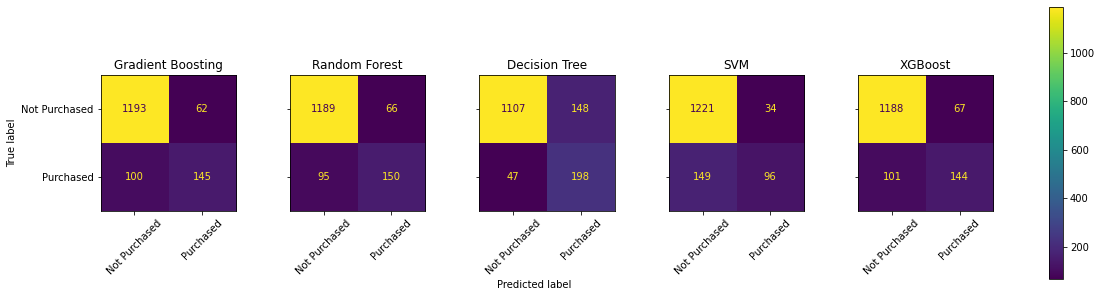

In [ ]:
classifiers = {
    "Gradient Boosting": gs_gbm,
    "Random Forest": gs_rf,
    "Decision Tree": gs_dt,
    "SVM": gs_svm,
    "XGBoost": gs_xgb
}

f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    print(key, " \n Accuracy:",accuracy_score(y_test,y_pred),"\n F-score",f1_score(y_test,y_pred))
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=["Not Purchased","Purchased"])
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

#### Now we will make a model out of our three best performing ones.

In [ ]:
# Combination of the three best models
estimators=[('Gradent Boosting', gs_gbm), ('Random Forest',gs_rf),('Decision Tree',gs_dt),('Support Vector Machine',gs_svm), ('XG Bosst', gs_xgb)]
ensemble = VotingClassifier(estimators, voting='hard')
ensemble.fit(X_train, y_train)
y_pred = ensemble.fit(X_train, y_train).predict(X_test)
print(" Accuracy : ",accuracy_score(y_test,y_pred),"\n F-score",f1_score(y_test,y_pred))

 Accuracy :  0.8906666666666667 
 F-score 0.6495726495726495


## STEP 7 : Export

### Exporting files for the API

#### In order to make our API we need to export all the processing our model. This will allow us to process our new data and make a prediction.

In [ ]:
# pickle.dump(ensemble, open('Flask_restful_api/model.pickle', 'wb'))
# pickle.dump(scalar, open('Flask_restful_api/scaler.pickle','wb'))
# pickle.dump(column_trans, open('Flask_restful_api/column_trans.pickle','wb'))